# Simulation of Optical Coherent Reciever System

In [568]:
"""
Cleaned up version of the integration imports we need to actually run this code together.
"""

import numpy as np
from optic.models.devices import mzm, photodiode, edfa, iqm, coherentReceiver, pdmCoherentReceiver, basicLaserModel
from optic.models.channels import linearFiberChannel, ssfm
from optic.comm.modulation import modulateGray, grayMapping
from optic.comm.sources import bitSource, symbolSource
from optic.dsp.core import upsample, pulseShape, pnorm, anorm, signalPower, firFilter, decimate, symbolSync,phaseNoise

try:
    from optic.dsp.coreGPU import checkGPU
    if checkGPU():
        from optic.dsp.coreGPU import firFilter
    else:
        from optic.dsp.core import firFilter
except ImportError:
    from optic.dsp.core import firFilter

from optic.utils import parameters, dBm2W
from optic.plot import eyediagram, pconst, plotPSD
import matplotlib.pyplot as plt
from scipy.special import erfc
from tqdm.notebook import tqdm
import scipy as sp
import scipy.constants as const

try:
    from optic.models.modelsGPU import manakovSSF
except:
    from optic.models.channels import manakovSSF

from optic.dsp.equalization import edc, mimoAdaptEqualizer, ffe
from optic.dsp.carrierRecovery import cpr
from optic.comm.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, calcEVM, bert
from optic.dsp.clockRecovery import gardnerClockRecovery


import logging as logg
logg.basicConfig(level=logg.INFO, format='%(message)s', force=True)
import time

In [569]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [570]:
np.random.seed(seed=123) # fixing the seed to get reproducible results

# Transmitter Code (From Leo)

In [571]:
"""
Single-channel QPSK coherent transmitter using OptiCommPy's IQM
(patterned after optic.models.tx.simpleWDMTx).

What you get:
- symbTx: QPSK symbols (unit-energy constellation by design)
- sigTx: pulse-shaped complex baseband (normalized to peak amplitude 1)
- sigLO: complex optical carrier field (unit amplitude, optional phase noise)
- sigTxo: modulated optical field at the transmitter output, with desired launch power

Key OptiCommPy conventions (same as simpleWDMTx):
1) Peak-normalize the pulse-shaped waveform: sigTx /= max(|sigTx|)
2) Drive IQM with a dimensionless "normalized voltage": u = mzmScale * sigTx
   where mzmScale is the modulation-depth knob (documented as ~ Vrf/Vpi).
3) Set actual launched optical power AFTER modulation:
   sigTxo = sqrt(P_launch) * pnorm(sigTxo)
"""
# Lady added some questions to be answered

# -------------------------
# 1) User parameters
# -------------------------
SpS = 16              # samples per symbol
Rs = 10e9             # symbol rate [baud]
Fs = Rs * SpS         # sampling frequency [Hz]
M = 4                 # QPSK -> M=4, constType='psk'

nBits = 100000        # total bits to generate
###################### Changed to match DPD paper ######################################################################
rollOff = 0.01        # RRC roll-off
nFilterTaps = 1024    # RRC filter taps

mzmScale = 0.5        # IQM drive scale (OptiCommPy default)
P_launch_dBm = 2      # desired launched optical power [dBm]
laserLinewidth = 100e3   # Hz (set e.g. 100e3 for phase noise), setting laserLineWidth to 0, models the ideal case 
seed = 12335          # RNG seed

# -------------------------
# 2) Symbol generation (QPSK)
# -------------------------
# In OptiCommPy, symbolSource() generates constellation symbols.
# With constType='qam' and M=4 -> QPSK. The symbol sequence is complex.
paramSymb = parameters()
paramSymb.nSymbols = int(nBits // np.log2(M))  # symbols = bits / log2(M)
paramSymb.M = M
paramSymb.constType = "qam"                    # 'qam' with M=4 -> QAM
paramSymb.dist = "uniform"                     # uniform symbol probabilities
paramSymb.seed = 123
paramSymb.shapingFactor = 0
symbTx = symbolSource(paramSymb)               # shape: (nSymbols,)

constSymb = grayMapping(paramSymb.M, paramSymb.constType)
if paramSymb.dist == "uniform":
   px = np.ones(paramSymb.M) / paramSymb.M
elif paramSymb.probDist == "maxwell-boltzmann":
   px = np.exp(-paramSymb.shapingFactor * np.abs(constSymb) ** 2)
   px = px / np.sum(px)
else:
   raise ValueError("Invalid probability distribution.")
paramSymb.px = px


# ===================================
# 2) Bit source parameters
# paramBits = parameters()
# paramBits.nBits = 100000  # number of bits to be generated
# paramBits.mode = 'prbs'   # mode of the bit source  
# paramBits.order = 23      # order of the PRBS
# paramBits.seed = 12335    # seed for the random number generator

# generate pseudo-random bit sequence
# bitsTx = bitSource(paramBits)
# print(bitsTx)

# generate 4-QAM modulated symbol sequence
########################### Why not psk? ############################################################
# symbTx = modulateGray(bitsTx, M, 'qam')
# print(symbTx[:10])


In [572]:
# -------------------------
# 3) Upsampling + pulse shaping (RRC)
# -------------------------
# Upsampling inserts SpS-1 zeros between symbols, then FIR filtering applies RRC.
paramPulse = parameters()
paramPulse.pulseType = "rrc"
paramPulse.nFilterTaps = nFilterTaps
paramPulse.rollOff = rollOff
paramPulse.SpS = SpS

pulse = pulseShape(paramPulse)                 # RRC impulse response

symbolsUp = upsample(symbTx, SpS)              # shape: (nSymbols*SpS,)
sigTx = firFilter(pulse, symbolsUp)            # pulse-shaped baseband waveform

sigTx_ = sigTx

# IMPORTANT: match simpleWDMTx() exactly:
# normalize waveform to peak amplitude 1 (NOT RMS). This makes drive scaling predictable.
sigTx = sigTx / np.max(np.abs(sigTx)) # + 1e-30


In [573]:
# -------------------------
# 4) Optical carrier / LO field (Ein)
# -------------------------
# OptiCommPy's simpleWDMTx creates a unit-amplitude optical field with optional phase noise:
# Ein(t) = exp(j*phi_pn(t)). This is then IQ-modulated.
if laserLinewidth and laserLinewidth > 0:
    phi_pn = phaseNoise(laserLinewidth, len(sigTx), 1 / Fs, seed=seed)
    sigLO = np.exp(1j * phi_pn)
    print('YES')
else:
    sigLO = np.ones_like(sigTx, dtype=complex)
    print('YES!')


YES


In [574]:
# -------------------------
# 5) IQ modulation using IQM
# -------------------------
# Drive signal u(t) is dimensionless in this convention:
# u(t) = mzmScale * sigTx(t)
# mzmScale is the "modulation depth" knob (documented as ~ Vrf/Vpi).

paramIQM = parameters()
paramIQM.Vpi = 2
paramIQM.VbI = -2
paramIQM.VbQ = -2
paramIQM.Vphi = 1

u_drive = mzmScale * sigTx
sigTxo = iqm(sigLO, u_drive, paramIQM)   # complex optical field at IQM output (still normalized power)


In [575]:
# -------------------------
# 6) Set launched optical power
# -------------------------
# pnorm() normalizes the optical field so that mean(|E|^2)=1.
# Then multiplying by sqrt(P) sets mean optical power to P (watts).
P_launch_W = dBm2W(P_launch_dBm)
sigTxo = np.sqrt(P_launch_W) * pnorm(sigTxo)

In [576]:
# -------------------------
# 7) Quick sanity checks
# -------------------------
print("nSymbols =", len(symbTx))
print("Waveform length =", len(sigTx), "samples")
print("Fs =", Fs/1e9, "GHz")
print("Drive max|u| =", np.max(np.abs(u_drive)))      # should be ~ mzmScale (since peak(sigTx)=1)
print("Launch power (W) ~", np.mean(np.abs(sigTxo)**2), "(target:", P_launch_W, ")")

nSymbols = 50000
Waveform length = 800000 samples
Fs = 160.0 GHz
Drive max|u| = 0.5
Launch power (W) ~ 0.0015848931924611163 (target: 0.0015848931924611136 )


(np.float64(-0.7778174593052022),
 np.float64(0.7778174593052022),
 np.float64(-0.7778174593052022),
 np.float64(0.7778174593052022))

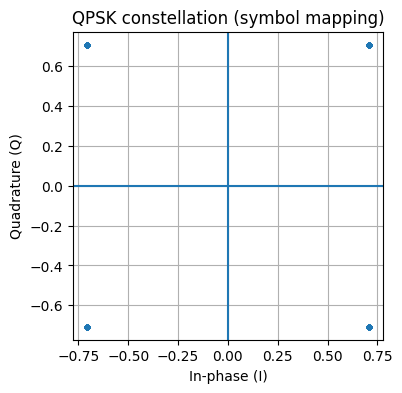

In [577]:
# CONSTELLATION DIAGRAM AFTER SYMBOL MAPPING WITH MY OWN FUNCTION

# When I change to psk this diagram changes, why? #############################################################

# plotting constellation diagram after symbol mapping
plt.figure(figsize=(4,4))
plt.scatter(np.real(symbTx), np.imag(symbTx), s=10)
plt.axhline(0); plt.axvline(0)
plt.grid(True)
plt.title("QPSK constellation (symbol mapping)")
plt.xlabel("In-phase (I)")
plt.ylabel("Quadrature (Q)")
plt.axis("equal")

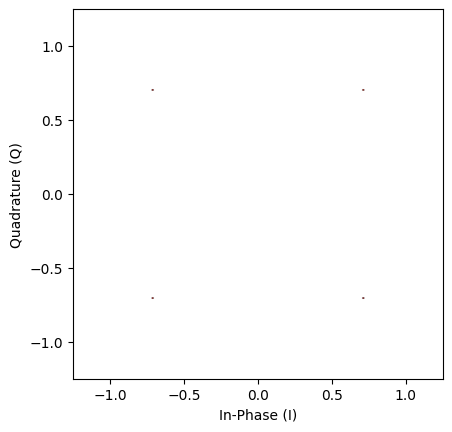

(<Figure size 640x480 with 1 Axes>,
 <ScatterDensityAxes: xlabel='In-Phase (I)', ylabel='Quadrature (Q)'>)

In [578]:
# CONSTELLATION DIAGRAM AFTER SYMBOL MAPPING WITH OPTICOMMPY LIBRARY FUNCTION

# plotting constellation diagram after symbol mapping
pconst(symbTx, lim=True, R=1.25, pType='fancy', cmap='turbo', whiteb=True)

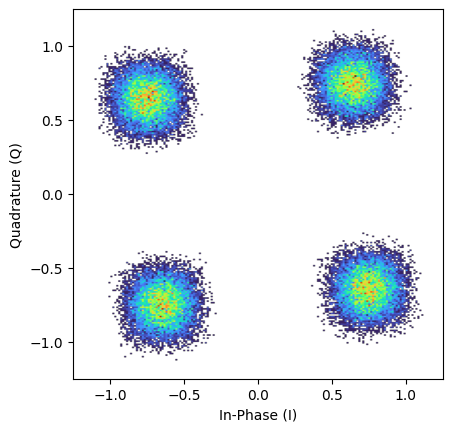

(<Figure size 640x480 with 1 Axes>,
 <ScatterDensityAxes: xlabel='In-Phase (I)', ylabel='Quadrature (Q)'>)

In [579]:
# CONSTELLATION DIAGRAM AFTER PULSE SHAPING (DAC) -> ANALOGUE WAVEFORM

# after pulse shapping
gd = (nFilterTaps - 1)//2
discard = gd + 200*SpS
z = sigTx[discard:-discard]
z_sym = z[::SpS]

# remove scale/rotation for display
n = min(len(z_sym), len(symbTx))
g = np.vdot(symbTx[:n], z_sym[:n]) / np.vdot(symbTx[:n], symbTx[:n])
z_eq = z_sym / g

pconst(z_eq, lim=True, R=1.25, pType='fancy')

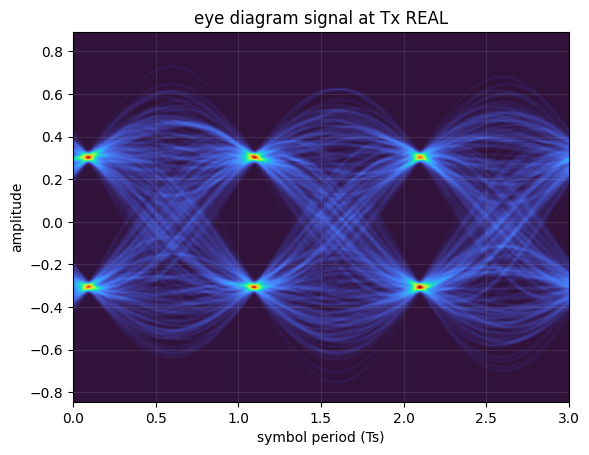

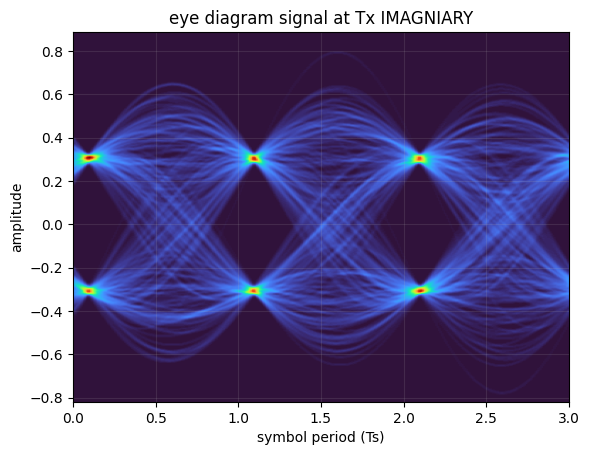

[-0.32337486 -0.31129198 -0.29979772 ... -0.25594176 -0.27517945
 -0.28799405]
792578


'\nThe Eye Diagrams for both I and Q axis are plotted. \nThe amplitude swings between -0.3 and +0.3, effectively crossing the 0-axix and creating an eye height of 0.6\nEach Eye Diagram therefore has 2 distinct amplitude levels: 2 * 2 = 4 symbols, thereofre validating the QPSK configuration of the system\nThe Eye Diagrams are evaluated at the Tx side (before optical modulation) to ensure that the transmitted signal meets the criteria before entering the channel\n'

In [580]:
# EYE DIAGRAMS AFTER PULSE SHAPPING AND BEFORE IQM

# plotting eye diagrams of sigTx
iscard = 50*SpS  # number of samples to discard at the beginning and end of the signal for eye diagram
eyediagram(sigTx.real[discard:-discard], sigTx.real.size-2*discard, SpS, plotlabel='signal at Tx REAL', ptype='fancy')
eyediagram(sigTx.imag[discard:-discard], sigTx.imag.size-2*discard, SpS, plotlabel='signal at Tx IMAGNIARY', ptype='fancy')
print(sigTx.real[discard:-discard])
print(sigTx.imag.size-2*discard)

# ==== Plot validation ====
"""
The Eye Diagrams for both I and Q axis are plotted. 
The amplitude swings between -0.3 and +0.3, effectively crossing the 0-axix and creating an eye height of 0.6
Each Eye Diagram therefore has 2 distinct amplitude levels: 2 * 2 = 4 symbols, thereofre validating the QPSK configuration of the system
The Eye Diagrams are evaluated at the Tx side (before optical modulation) to ensure that the transmitted signal meets the criteria before entering the channel
"""

In [581]:
# CREATING TIME INTERVAL FOR PSD AND TIME PLOTS

#From simpleWDMTx Ts
# interval and time
# transmitter parameters
Ts = 1 / Rs  # symbol period [s]
# Fs = 1 / (Ts / param.SpS)  # sampling frequency [samples/s]
interval = np.arange(16*20, 16*50)
t = interval * Ts / 1e-9

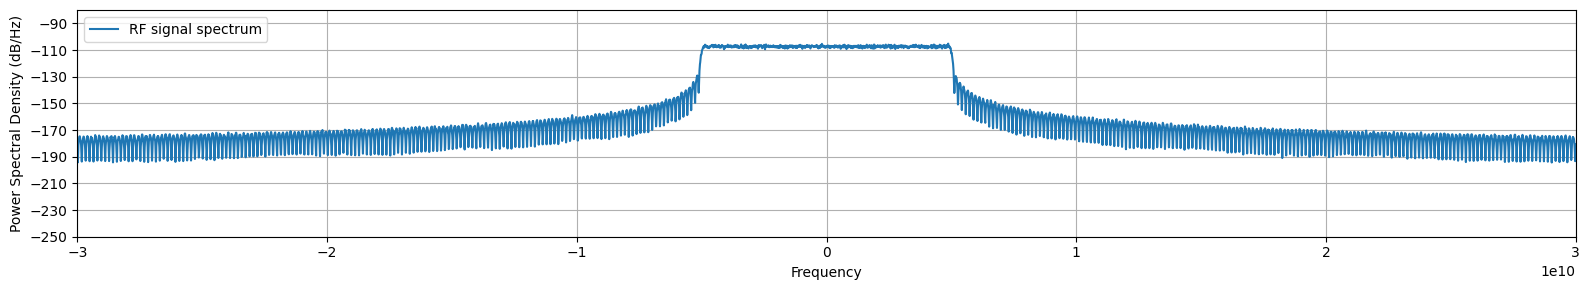

'\nThe RRC Filter Spectrum has a bandwidth of: B = Rs/2 * (1 + a)\nTherefore the theoretical/expected bandwidth is B = 10e9/2 * (1+0.01) = 5.05*10e8 Herz\nFrom the graph we read off aproximately 0.5 * 1e10  Herz\nAs a result theory matches expectation\n\nIt is important to mention the effect of the size of the FFT (N) in pulse shapping. \nA higher N leads to:\n       - higher accuracy\n       - reduced side lobes (out of band emissions)\n       - minimized ISI by decreasing corss-talk between adjacent symbols\n       - increases computational complexity and effort\nAs a conclusion: a larger FFT allows for more precise frequenct-domain shaping, creating a tigher (more dense spectrum) \nand less interference, but increases the computational load\n'

In [582]:
# ===== RF PSD plot =====
fig, ax = plt.subplots(figsize=(16, 3))

ax.set_xlim(-3*Rs, 3*Rs)
ax.set_ylim(-250, -80)
ax.psd(sigTx, Fs=Fs, NFFT=16*1024, sides='twosided',
       label='RF signal spectrum')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

# ==== Plot validation ====
"""
The RRC Filter Spectrum has a bandwidth of: B = Rs/2 * (1 + a)
Therefore the theoretical/expected bandwidth is B = 10e9/2 * (1+0.01) = 5.05*10e8 Herz
From the graph we read off aproximately 0.5 * 1e10  Herz
As a result theory matches expectation

It is important to mention the effect of the size of the FFT (N) in pulse shapping. 
A higher N leads to:
       - higher accuracy
       - reduced side lobes (out of band emissions)
       - minimized ISI by decreasing corss-talk between adjacent symbols
       - increases computational complexity and effort
As a conclusion: a larger FFT allows for more precise frequenct-domain shaping, creating a tigher (more dense spectrum) 
and less interference, but increases the computational load
"""


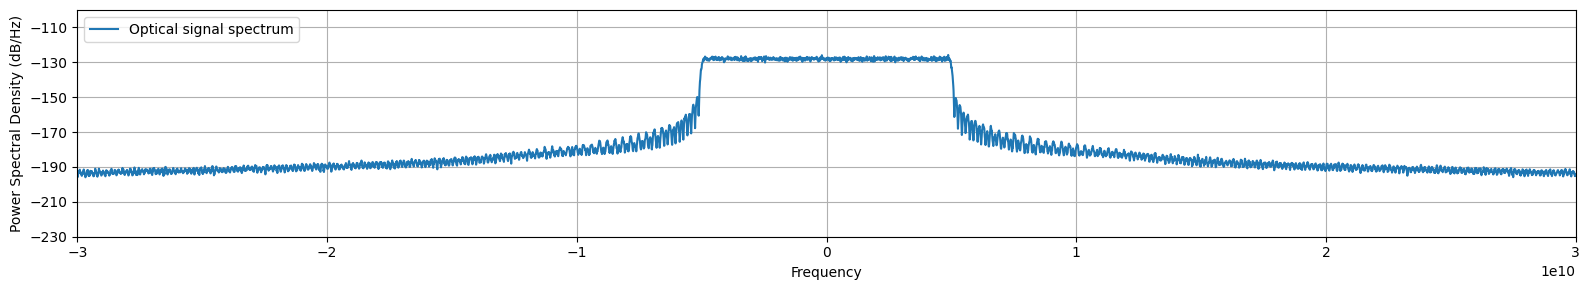

In [583]:
# ===== Optical PSD plot =====
fig, ax = plt.subplots(figsize=(16, 3))

# switch between sigTxo and np.abs(sigTxo)**2

ax.set_xlim(-3*Rs, 3*Rs)
ax.set_ylim(-230, -100)
ax.psd(sigTxo, Fs=Fs, NFFT=16*1024, sides='twosided',
       label='Optical signal spectrum')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

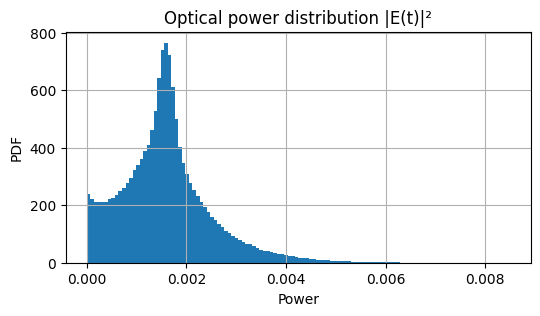

In [584]:
# ===== Optical Power Histogram =====
Pmid = np.abs(sigTxo)**2
Pmid = Pmid[discard:-discard]

plt.figure(figsize=(6,3))
plt.hist(Pmid, bins=120, density=True)
plt.title("Optical power distribution |E(t)|²")
plt.xlabel("Power"); plt.ylabel("PDF")
plt.grid(True)

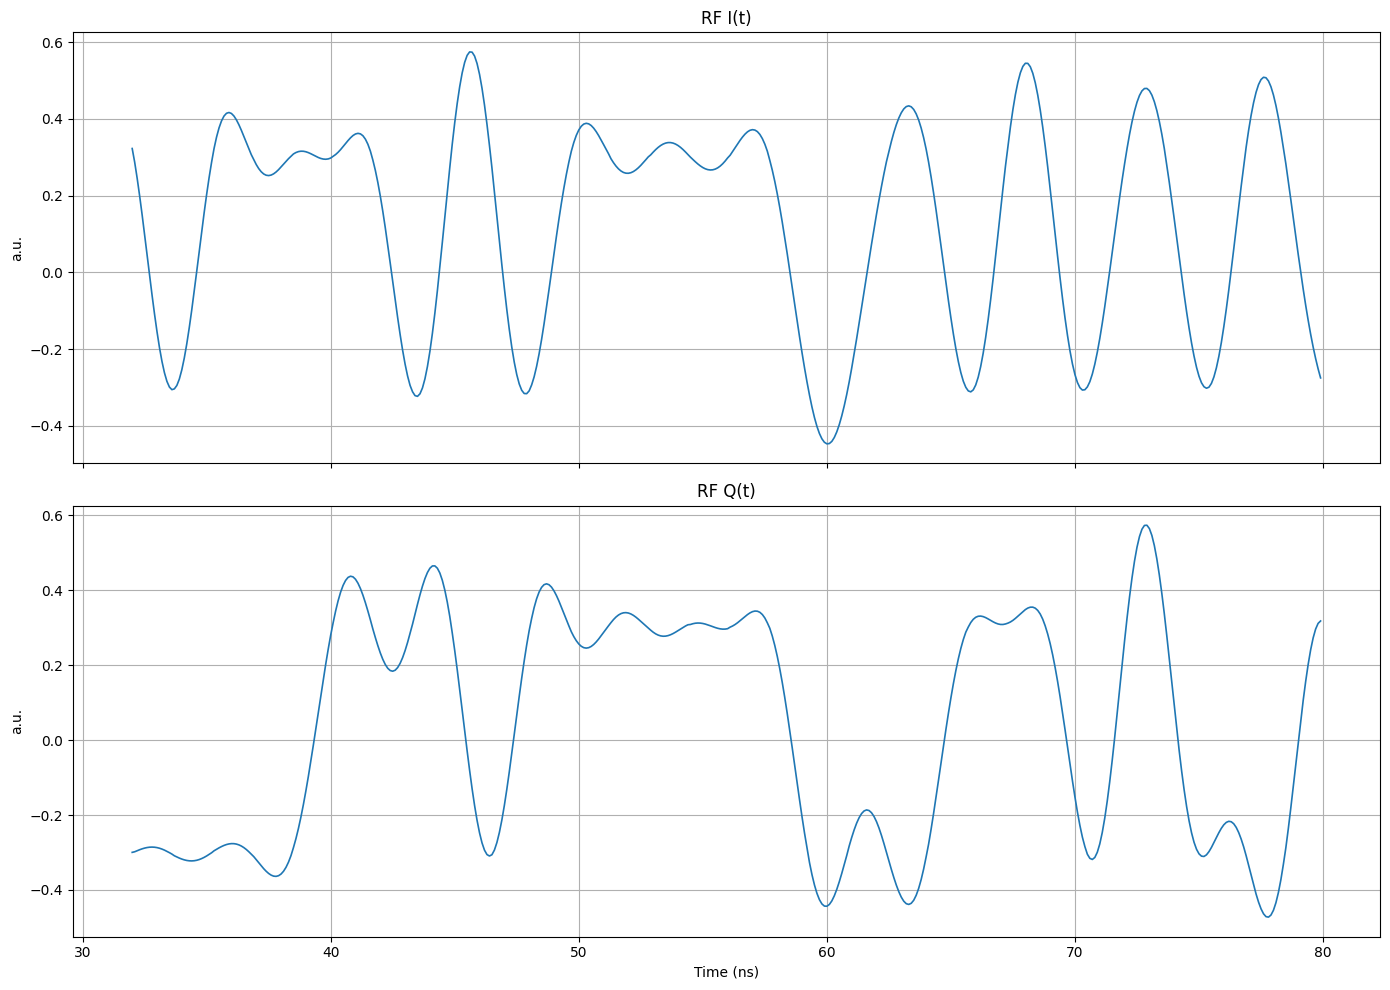

In [585]:
# ===== Electrical Waveform Real and Imaginary Part Vs Time =====
fig, axs = plt.subplots(2, 1, figsize=(14,10), sharex=True)
axs[0].plot(t, np.real(sigTx[interval]), linewidth=1.2)
axs[0].set_title("RF I(t)")
axs[1].plot(t, np.imag(sigTx[interval]), linewidth=1.2)
axs[1].set_title("RF Q(t)")
for ax in axs:
    ax.grid(True)
    ax.set_ylabel("a.u.")

axs[-1].set_xlabel("Time (ns)")
plt.tight_layout()

# Improvised Channel (non-linear Single polarization) (by Lady)

In [586]:
"""
Took the parameters suggested by Atahan to create a non-linear single polarization channel 
"""
# -------------------------
# 1) Optical Channel Set up Function
# -------------------------
# optical channel parameters
paramCh = parameters()
paramCh.Ltotal = 400     # total link distance [km]
paramCh.Lspan  = 50      # span length [km]
paramCh.alpha = 0.2      # fiber loss parameter [dB/km]
paramCh.D = 16           # fiber dispersion parameter [ps/nm/km]
paramCh.gamma = 1.3      # fiber nonlinear parameter [1/(W.km)]
paramCh.Fc = 193.1e12      # central optical frequency of the WDM spectrum
paramCh.hz = 0.5         # step-size of the split-step Fourier method [km]
paramCh.prgsBar = True   # show progress bar
paramCh.Fs = Rs*SpS # sampling rate
paramCh.amp = 'edfa'
paramCh.NF = 4.5

############################### Question: Is this correct or are we missing any variables ################################

"""
Contains an edfa it runs inside of the function with default parameters

"""
sigCh = ssfm(sigTxo, paramCh)



  0%|          | 0/8 [00:00<?, ?it/s]

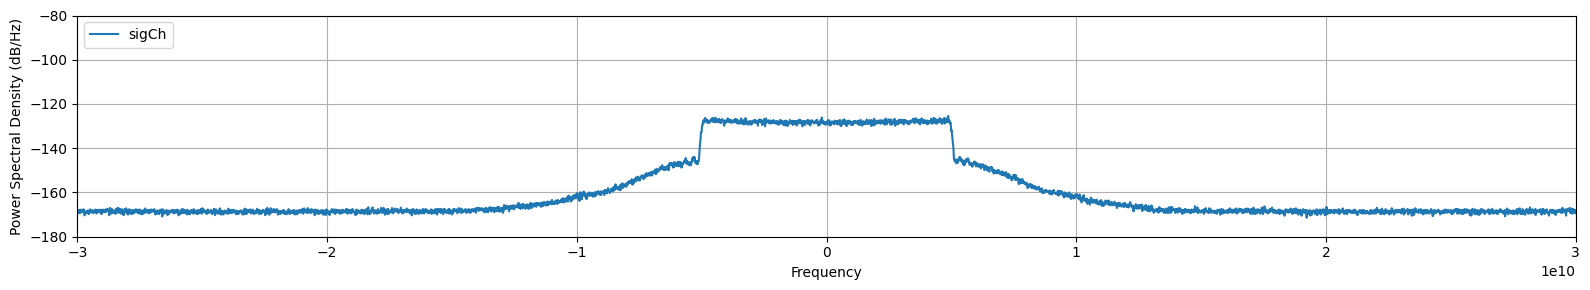

In [587]:
# ===== RF PSD plot =====
fig, ax = plt.subplots(figsize=(16, 3))

ax.set_xlim(-3*Rs, 3*Rs)
ax.set_ylim(-180, -80)
ax.psd(sigCh, Fs=Fs, NFFT=16*1024, sides='twosided',
       label='sigCh')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

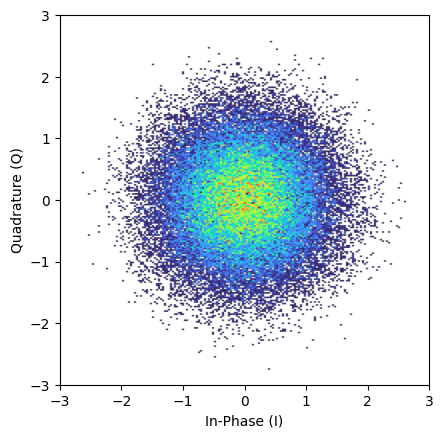

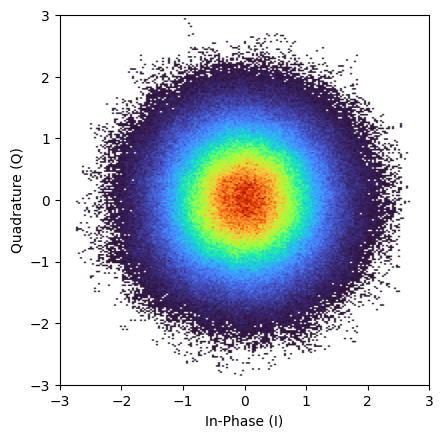

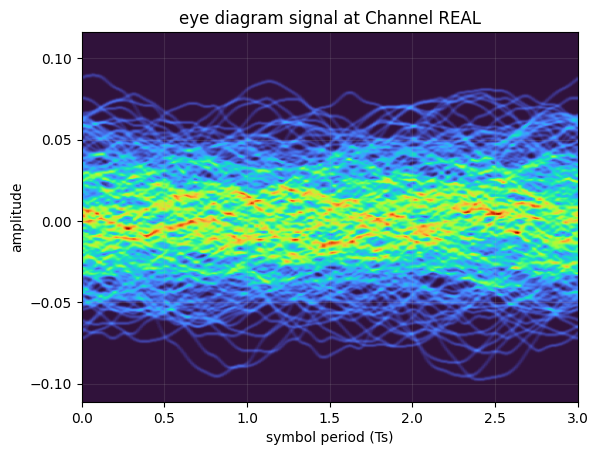

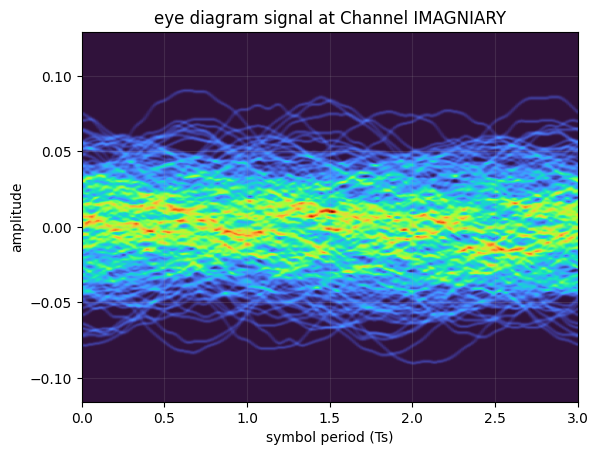

In [588]:
# plot received constellations
############################################# Not sure which version is "correct"################################################
pconst(sigCh[0::SpS], R=3);
pconst(sigCh, lim=True, R=3, pType='fancy')

#Eye Diagram

# plotting eye diagrams of sigTx
discard = 50*SpS  # number of samples to discard at the beginning and end of the signal for eye diagram
eyediagram(sigCh.real[discard:-discard], sigCh.real.size-2*discard, SpS, plotlabel='signal at Channel REAL', ptype='fancy')
eyediagram(sigCh.imag[discard:-discard], sigCh.imag.size-2*discard, SpS, plotlabel='signal at Channel IMAGNIARY', ptype='fancy')

# Coherent Detection, DSP and Data Demodulation for QPSK (by Lady)

Local oscillator P: 10.00 dBm, lw: 100.00 kHz, FO: -128.00 MHz



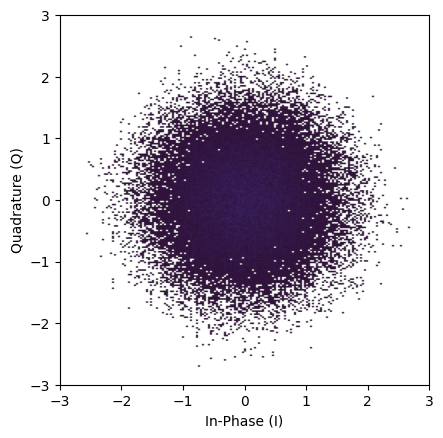

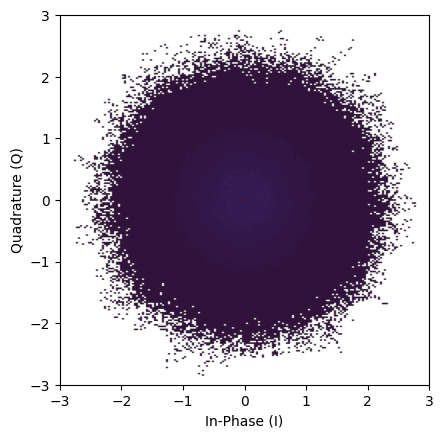

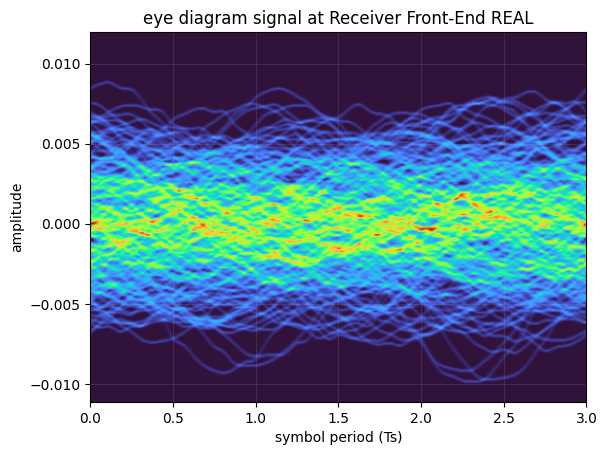

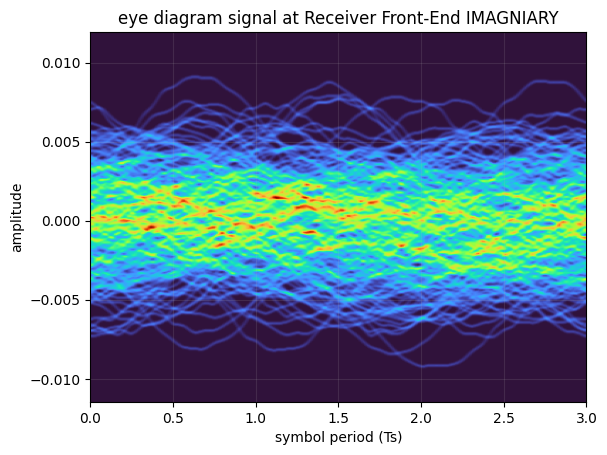

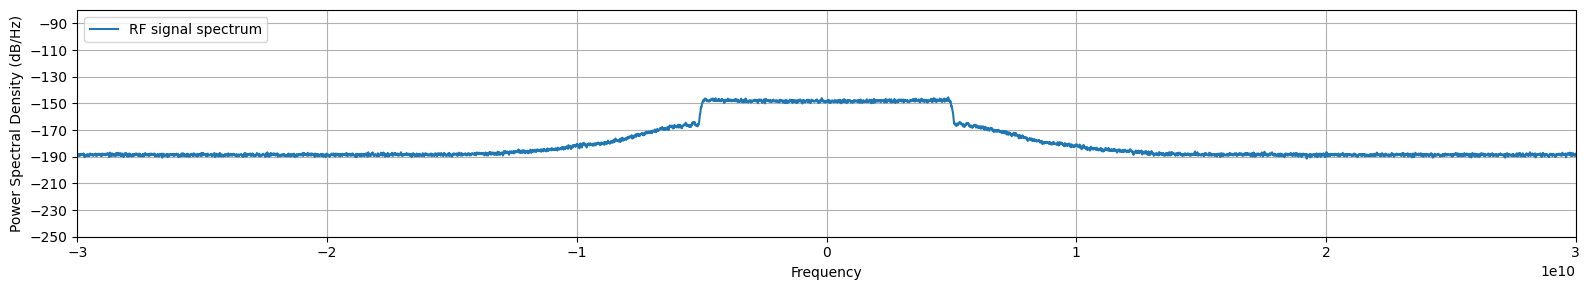

In [589]:

# ----------------------------------------------------------
# 1) Local Oscillator parameters and basic Laser Model Output
# ----------------------------------------------------------

# local oscillator (LO) parameters:
FO  = -128e6                 # frequency offset
paramLO = parameters()
paramLO.P = 10              # power in dBm
paramLO.lw = 100e3          # laser linewidth
paramLO.RIN_var = 0
paramLO.Ns = len(sigCh)
#paramLO.Ns = len(sigTxo)
paramLO.Fs = Fs
paramLO.seed = 789 # random seed for noise generation

############################ Question: Unsure about frequency Shift and offset value ##############################################
#paramLO.freqShift = freqGrid[chIndex] + FO  # OUTPUT from example of freqGrid[chIndex] = 0 so its 0 + FO
paramLO.freqShift = 0   # downshift of the channel to be demodulated add frequency offset

# generate CW laser LO field
sigLO = basicLaserModel(paramLO)

print('Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz\n'\
      %(paramLO.P, paramLO.lw/1e3, FO/1e6))

# -----------------------------------------------------------------------
# 2) Front-End Parameters and photodiode paramters
# ------------------------------------------------------------------------

######################################### Question: What are the phaseImb and ampImb supposed to be #########################################

# Frontend parameters
#paramFE = parameters()
#paramFE.Fs = Fs
#paramFE.polRotation = np.pi/3    # input polarization rotation angle
#paramFE.pdl = 0                  # Polarization dependent loss
#paramFE.polDelay = 4e-12         # Polarization delay
#paramFE.phaseImbX = 0*np.pi/180  # IQ phase imbalance polarization X in radians #Can check
#paramFE.phaseImbY = 0*np.pi/180  # IQ phase imbalance polarization Y in radians
#paramFE.ampImbX = 0              # IQ amplitude imbalance polarization X in dB
#paramFE.ampImbY = 0              # IQ amplitude imbalance polarization Y in dB

# Frontend parameters
paramFE = parameters()
paramFE.Fs = Fs
#paramFE.phaseImb= 0*np.pi/180
paramFE.phaseImb= 0
paramFE.ampImb= 0

# Photodiodes parameters
paramPD = parameters()
paramPD.B = Rs
paramPD.Fs = Fs
paramPD.ideal = True
paramPD.seed = 1011

# ------------------------------------------------------------------------------------------------
# 2) Coherent Reciever for single-polarization. 
# ------------------------------------------------------------------------------------------------
#Contains a 90 hybrid, two balanced photodiodes and iqmixing
sigRxFrontEnd = coherentReceiver(sigCh, sigLO, paramFE, paramPD)
#sigRxFrontEnd = coherentReceiver(sigTxo, sigLO, paramFE, paramPD)

# plot received constellations
############################################# Not sure which version is "correct"################################################
pconst(sigRxFrontEnd[0::SpS],R =3, cmap='turbo');
pconst(sigRxFrontEnd, lim=True, R=3, pType='fancy')


#Eye Diagram
iscard = 50*SpS  # number of samples to discard at the beginning and end of the signal for eye diagram
eyediagram(sigRxFrontEnd.real[discard:-discard], sigRxFrontEnd.real.size-2*discard, SpS, plotlabel='signal at Receiver Front-End REAL', ptype='fancy')
eyediagram(sigRxFrontEnd.imag[discard:-discard], sigRxFrontEnd.imag.size-2*discard, SpS, plotlabel='signal at Receiver Front-End IMAGNIARY', ptype='fancy')

# ===== RF PSD plot =====
fig, ax = plt.subplots(figsize=(16, 3))

ax.set_xlim(-3*Rs, 3*Rs)
ax.set_ylim(-250, -80)
ax.psd(sigRxFrontEnd, Fs=Fs, NFFT=16*1024, sides='twosided',
       label='RF signal spectrum')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()


Matched filtering took 0.14 seconds.


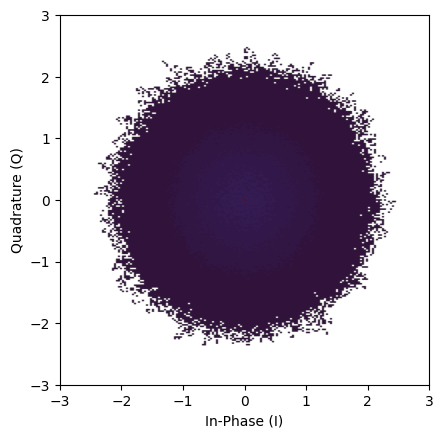

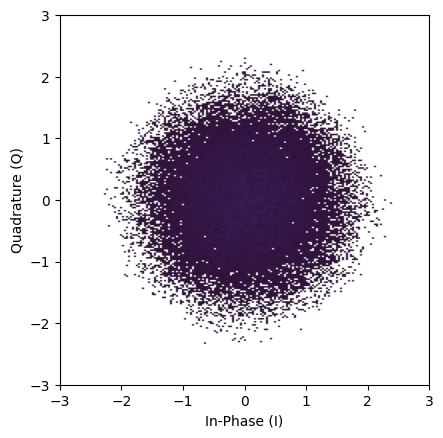

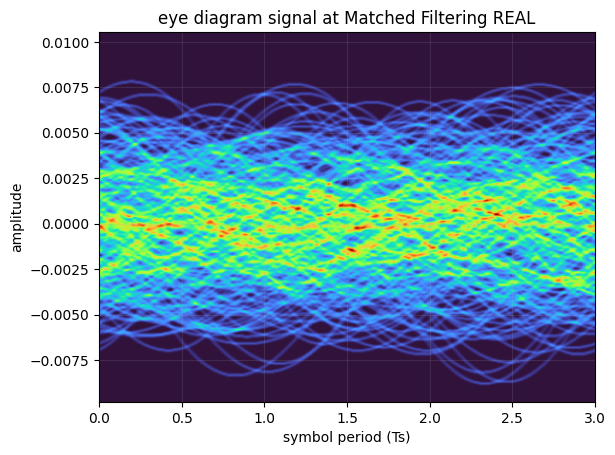

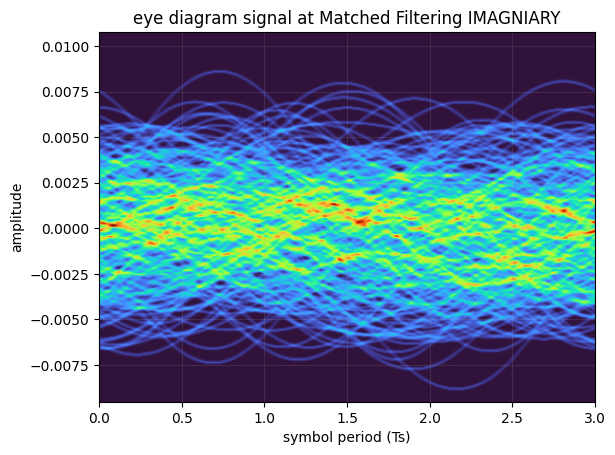

In [590]:
# ------------------------------------------------------------------------------------------------
# 3) Rx Filtering - Matched Filtering
# ------------------------------------------------------------------------------------------------

paramRxPulse = parameters()
paramRxPulse.SpS = paramPulse.SpS = SpS
paramRxPulse.nFilterTaps = nFilterTaps
paramRxPulse.rollOff = rollOff
paramRxPulse.pulseType = "rrc"
pulse = pulseShape(paramRxPulse) 

start = time.time()
sigRxPulseShape = firFilter(pulse, sigRxFrontEnd)
end = time.time()
timeMF = end - start
print(f"Matched filtering took {timeMF:.2f} seconds.")

############################################# Not sure which version is "correct"################################################
# plot constellations after matched filtering
pconst(sigRxPulseShape, lim=True, R=3, pType='fancy')
pconst(sigRxPulseShape[0::SpS], R=3)

# Eye diagram
iscard = 5000  # number of samples to discard at the beginning and end of the signal for eye diagram
eyediagram(sigRxPulseShape.real[discard:-discard], sigRxPulseShape.real.size-2*discard, SpS, plotlabel='signal at Matched Filtering REAL', ptype='fancy')
eyediagram(sigRxPulseShape.imag[discard:-discard], sigRxPulseShape.imag.size-2*discard, SpS, plotlabel='signal at Matched Filtering IMAGNIARY', ptype='fancy')

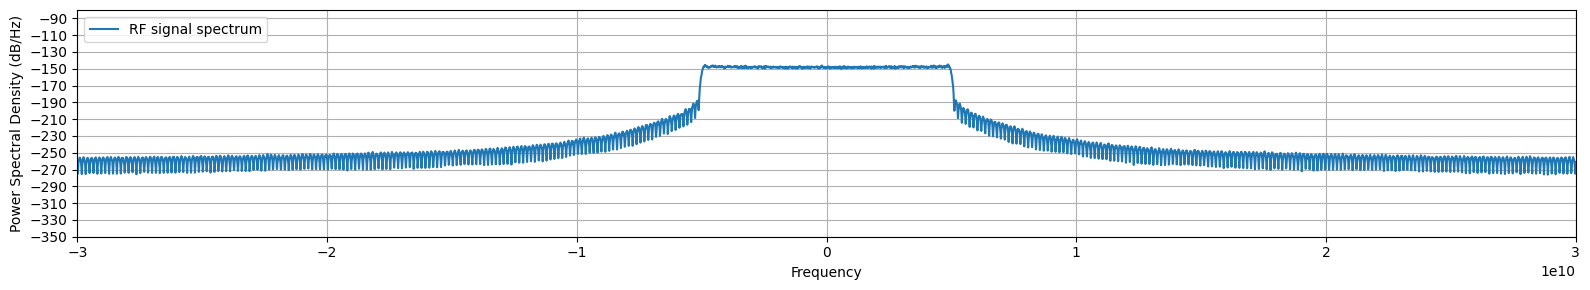

In [591]:
# ===== RF PSD plot =====
fig, ax = plt.subplots(figsize=(16, 3))

ax.set_xlim(-3*Rs, 3*Rs)
ax.set_ylim(-350, -80)
ax.psd(sigRxPulseShape, Fs=Fs, NFFT=16*1024, sides='twosided',
       label='RF signal spectrum')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [592]:
# ------------------------------------------------------------------------------------------------
# 4) Decimation to 2 samples/symbol
# ------------------------------------------------------------------------------------------------
paramDec = parameters()
paramDec.SpSin  = SpS
paramDec.SpSout = 2

start = time.time()
sigRxDecimation = decimate(sigRxPulseShape, paramDec)
end = time.time()
timeDec = end - start
print(f"Decimation took {timeDec:.2f} seconds.")
print(len(sigRxDecimation))

Decimation took 0.03 seconds.
100000


In [593]:
# ------------------------------------------------------------------------------------------------
# 5) Clock Recovery (to reduce jitter in eye diagrams) TBD
# ------------------------------------------------------------------------------------------------

#sigRx= gardnerClockRecovery(sigRx, None)

Running CD compensation...
CD filter length: 22 taps, FFT size: 32


CD compensation took 0.09 seconds.


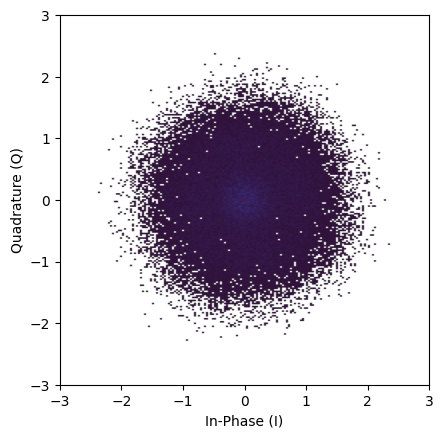

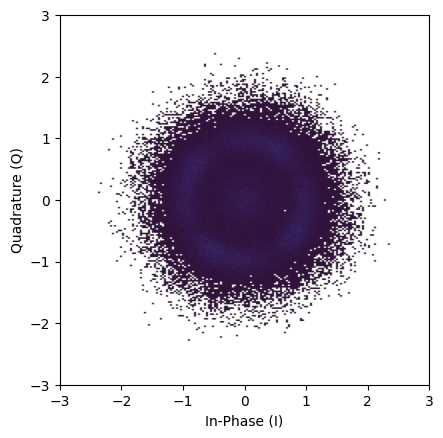

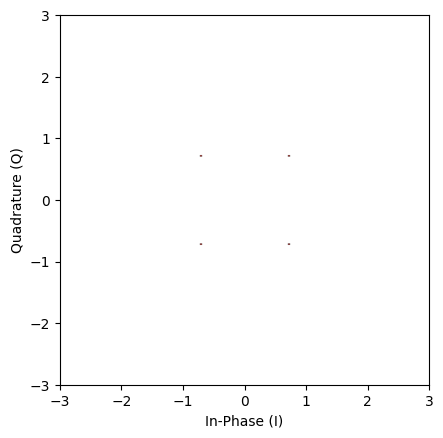

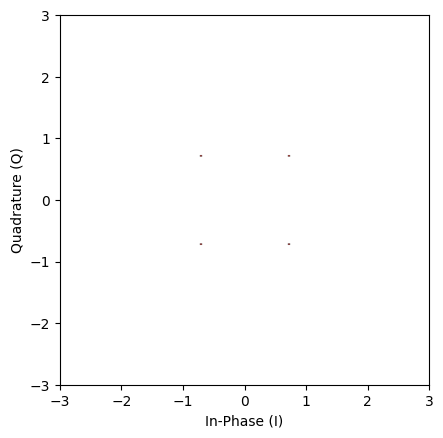

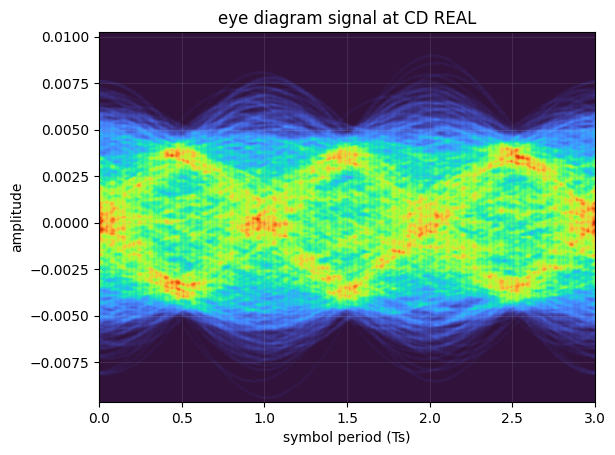

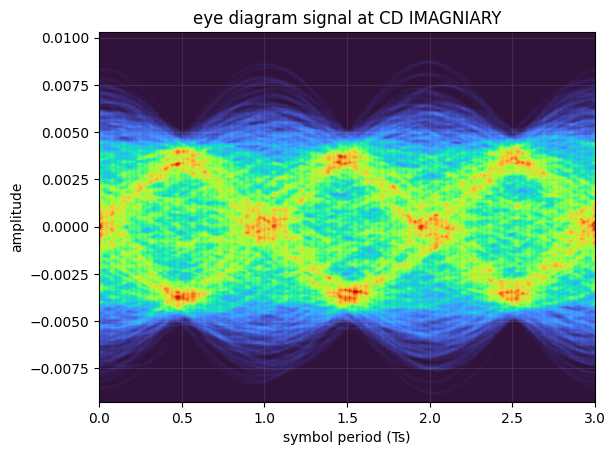

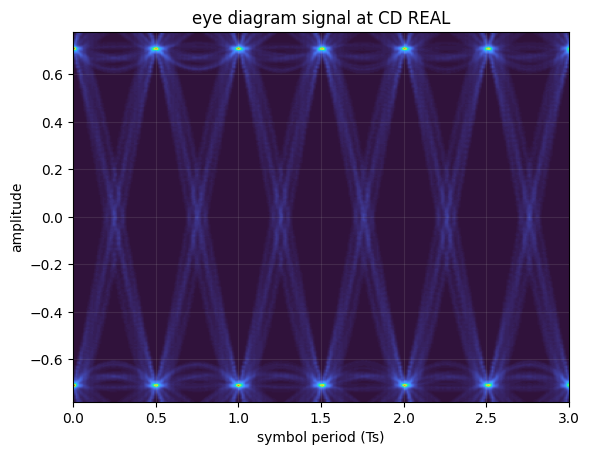

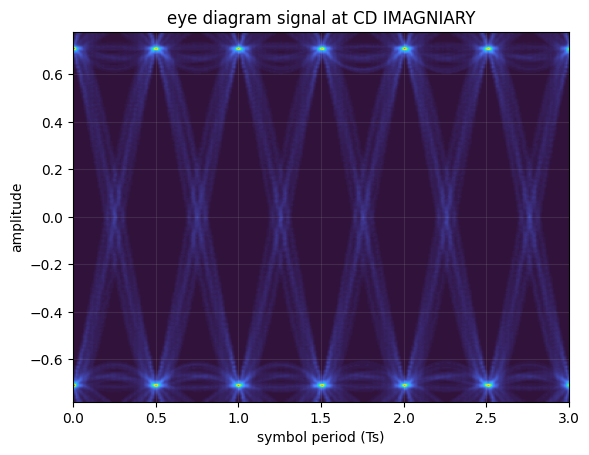

In [594]:
# ------------------------------------------------------------------------------------------------
# 6) Chromatic Dispersion Compensation for non-linear channel
# ------------------------------------------------------------------------------------------------
paramEDC = parameters()
paramEDC.L = paramCh.Ltotal
paramEDC.D = paramCh.D
paramEDC.Fc = paramCh.Fc
paramEDC.Rs = Rs

#################################### Question: Why is Fs 2*Rs ############################################################################
paramEDC.Fs = 2*Rs

start = time.time()
sigRxCD = edc(sigRxDecimation, paramEDC)
end = time.time()
timeCDcomp = end - start
print(f"CD compensation took {timeCDcomp:.2f} seconds.")

############################################# Not sure which version is "correct"##############################################
# plot constellations after CD compensation
pconst(sigRxCD[0::2], R=3);
pconst(sigRxCD, lim=True, R=3, pType='fancy')
#pconst(sigRxDecimation[0::2], R=3);
#pconst(sigRxDecimation, lim=True, R=3, pType='fancy')

# re-synchronization with transmitted sequences
symbRxCD = symbolSync(sigRxCD, symbTx, 2)
#symbRxCD = symbolSync(sigRxDecimation, symbTx, 2)
pconst(symbRxCD[0::2], R=3);
pconst(symbRxCD, lim=True, R=3, pType='fancy')

# Eye diagram
discard = 5000  # number of samples to discard at the beginning and end of the signal for eye diagram
eyediagram(sigRxCD.real[discard:-discard], sigRxCD.real.size-2*discard, paramDec.SpSout, plotlabel='signal at CD REAL', ptype='fancy')
eyediagram(sigRxCD.imag[discard:-discard], sigRxCD.imag.size-2*discard, paramDec.SpSout, plotlabel='signal at CD IMAGNIARY', ptype='fancy')
#eyediagram(sigRxDecimation.real[discard:-discard], sigRxCD.real.size-2*discard, SpS, plotlabel='signal at CD REAL', ptype='fancy')
#eyediagram(sigRxDecimation.imag[discard:-discard], sigRxCD.imag.size-2*discard, SpS, plotlabel='signal at CD IMAGNIARY', ptype='fancy')
eyediagram(symbRxCD.real[discard:-discard], symbRxCD.real.size, paramDec.SpSout, plotlabel='signal at CD REAL', ptype='fancy')
eyediagram(symbRxCD.imag[discard:-discard], symbRxCD.imag.size, paramDec.SpSout, plotlabel='signal at CD IMAGNIARY', ptype='fancy')


In [595]:
# ------------------------------------------------------------------------------------------------
# 7) Power Normalization
# ------------------------------------------------------------------------------------------------
x = pnorm(sigRxCD) 
#x = pnorm(sigRxDecimation)
d = pnorm(symbRxCD)

Running adaptive equalizer...
cma - training stage #0


cma pre-convergence training iteration #0
cma MSE = 0.061352.
cma pre-convergence training iteration #1
cma MSE = 0.032743.
cma - training stage #1
cma MSE = 0.048473.


Adaptive equalization took 0.12 seconds.



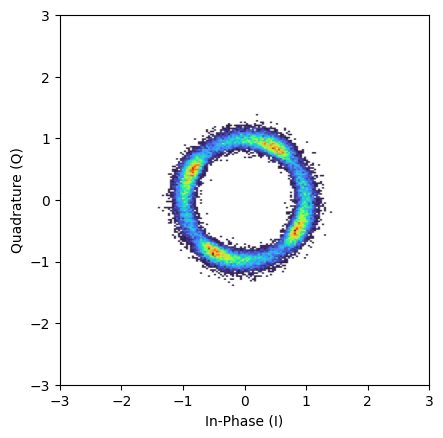

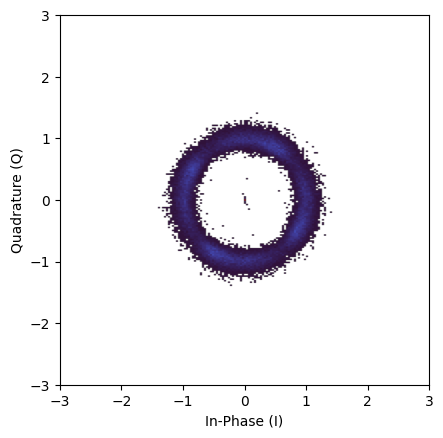

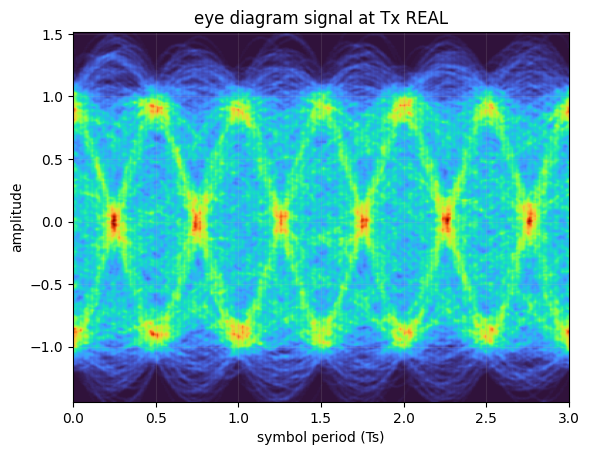

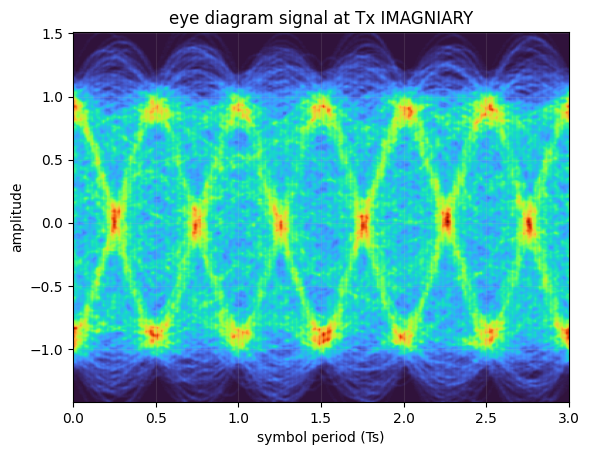

In [596]:
# ------------------------------------------------------------------------------------------------
# 7) Adaptive Equalization Parameters
# ------------------------------------------------------------------------------------------------
paramEq = parameters()
paramEq.nTaps = 35
paramEq.SpS = paramDec.SpSout
paramEq.numIter = 2
paramEq.storeCoeff = False
paramEq.M = M
paramEq.shapingFactor = 0
paramEq.L = [int(0.2*d.shape[0]), int(0.8*d.shape[0])]
paramEq.constType = "qam"
paramEq.prgsBar = False

############################################# Could we use another algorithm that gives us better performance?############################
# Since we are doing M=4, cma is used.
if M == 4:
    paramEq.alg = ['cma','cma'] # QPSK
    paramEq.mu = [5e-3, 1e-3]
else:
    paramEq.alg = ['da-rde','rde'] # M-QAM
    paramEq.mu = [5e-3, 5e-4] 

start = time.time()
y_EQ = mimoAdaptEqualizer(x, paramEq, d)
end = time.time()
timeEq = end - start
print(f"Adaptive equalization took {timeEq:.2f} seconds.")

#Y_EQ1 = ffe(x, d,paramEq)
#pconst(Y_EQ1[discard:-discard], R=3);
#pconst(Y_EQ1, lim=True, R=3, pType='fancy')

# Eye diagram
#discard2 = 5000  # number of samples to discard at the beginning and end of the signal for eye diagram
#eyediagram(Y_EQ1.real[discard2:-discard2], Y_EQ1.real.size-2*discard2, SpS, plotlabel='signal at Tx REAL', ptype='fancy')
#eyediagram(Y_EQ1.imag[discard2:-discard2], Y_EQ1.imag.size-2*discard2, SpS, plotlabel='signal at Tx IMAGNIARY', ptype='fancy')

print()
############################################# Not sure which version is "correct"##############################################
#plot constellations after adaptive equalization
discard = 5000
pconst(y_EQ[discard:-discard], R=3);
pconst(y_EQ, lim=True, R=3, pType='fancy')

# Eye diagram
discard2 = 5000  # number of samples to discard at the beginning and end of the signal for eye diagram
eyediagram(y_EQ.real[discard2:-discard2], y_EQ.real.size-2*discard2, paramDec.SpSout, plotlabel='signal at Tx REAL', ptype='fancy')
eyediagram(y_EQ.imag[discard2:-discard2], y_EQ.imag.size-2*discard2, paramDec.SpSout, plotlabel='signal at Tx IMAGNIARY', ptype='fancy')

Running frequency offset compensation...
Estimated frequency offset (MHz): [-0.05]
Running BPS carrier phase recovery...
Estimated linewidth: 162.261 kHz


CPR took 0.61 seconds.


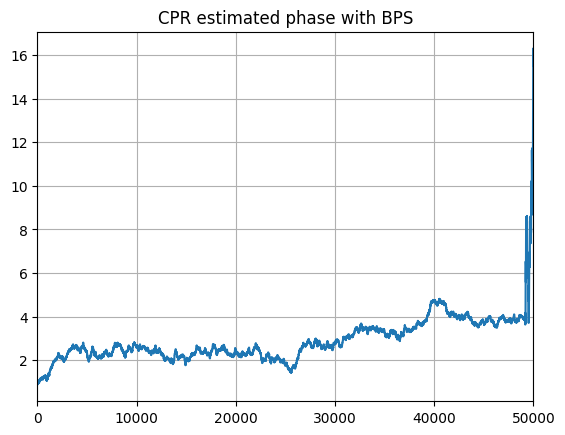

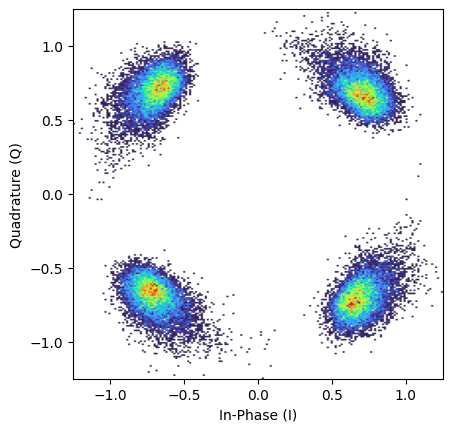

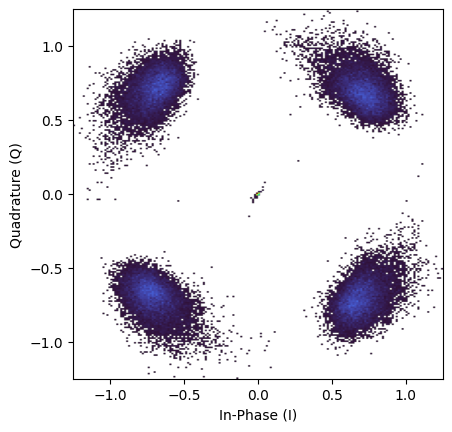

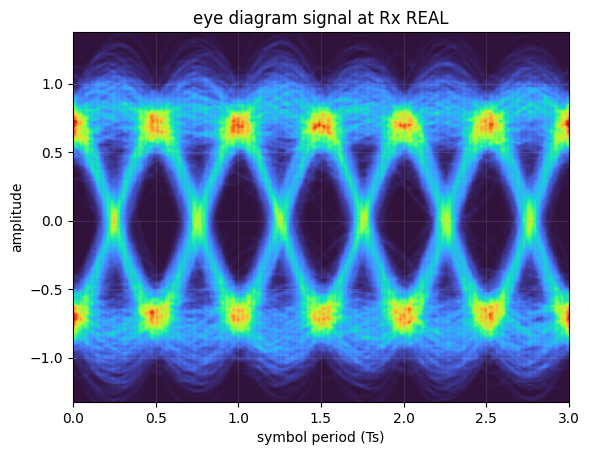

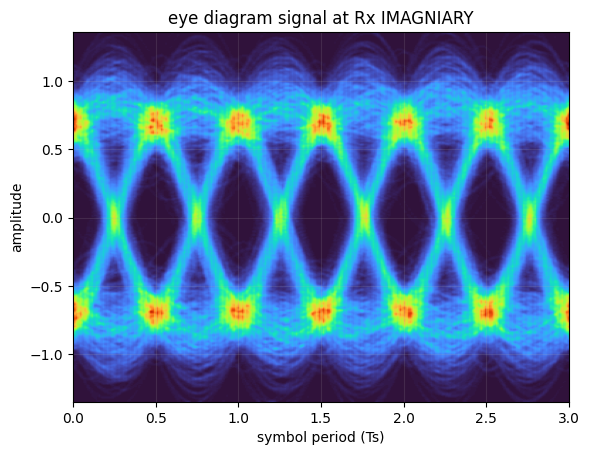

In [597]:
# ------------------------------------------------------------------------------------------------
# 7) Carrier and phase recovery trials
# ------------------------------------------------------------------------------------------------
############################### Which algorithm performs better? ###########################################
# Trial 1 with bps

paramCPR = parameters()
paramCPR.alg = 'bps'
paramCPR.M   = M
paramCPR.constType ="qam"
paramCPR.shapingFactor = 0
paramCPR.N   = 40
paramCPR.B   = 64
paramCPR.returnPhases = True
paramCPR.Ts = 1/Rs

start = time.time()
y_CPR_1, θ = cpr(y_EQ, paramCPR)
end = time.time()
timeCPR = end - start
print(f"CPR took {timeCPR:.2f} seconds.")

plt.figure()
plt.title('CPR estimated phase with BPS')
plt.plot(θ,'-')
plt.xlim(0, len(θ))
plt.grid();

discard = 5000
# plot constellations
#pconst([y_CPR_1[discard:-discard],d[discard:-discard]], pType='fast')
pconst(y_CPR_1[discard:-discard], cmap='turbo')
pconst(y_CPR_1, lim=True, R=1.25, pType='fancy', cmap='turbo', whiteb=True)


# plotting eye diagrams of sigTx
discard2 = 5000  # number of samples to discard at the beginning and end of the signal for eye diagram
eyediagram(y_CPR_1.real[discard2:-discard2], y_CPR_1.real.size-2*discard2, paramDec.SpSout, plotlabel='signal at Rx REAL', ptype='fancy')
eyediagram(y_CPR_1.imag[discard2:-discard2], y_CPR_1.imag.size-2*discard2, paramDec.SpSout, plotlabel='signal at Rx IMAGNIARY', ptype='fancy')


In [598]:
print(len(y_CPR_1), len(symbTx), Ts)

50000 50000 1e-10


In [599]:
discard = 5000
ind = np.arange(discard, len(symbTx) - discard)

# remove phase ambiguity for 4-QAM/QPSK
if M == 4:
    # reference symbols
    d = symbTx

    # estimate constant complex rotation (and scale) between Rx and Tx
    rot = np.mean(pnorm(d[ind]) / pnorm(y_CPR_1[ind]))

    # undo rotation/scale
    y_CPR_1_corr = pnorm(rot * y_CPR_1)
else:
    y_CPR_1_corr = pnorm(y_CPR_1)

# now compute metrics (both are 1 sample/symbol and same length)
BER, SER, SNR = fastBERcalc(y_CPR_1_corr[ind], pnorm(symbTx)[ind], M, 'qam', px = paramSymb.px)
EVM = calcEVM(y_CPR_1_corr[ind], M, 'qam', pnorm(symbTx)[ind])


print(' SER: %.3e,  '%(SER[0]))
print(' BER: %.3e   '%(BER[0]))
print(' SNR: %.3f dB'%(SNR[0]))
print(' EVM: %.3f %%'%(EVM[0]*100))


 SER: 3.250e-04,  
 BER: 1.625e-04   
 SNR: 15.628 dB
 EVM: 2.739 %


# Performance Metrics

In [600]:

# calculate the BER and Q-factor
BER, Q = bert(y_CPR_1_corr)

print("\nTransmission performance metrics:")
print(f"Q-factor = {Q:.2f} ")
print(f"BER = {BER:.2e}")

# theoretical error probability from Q-factor
Pb = 0.5 * erfc(Q / np.sqrt(2))
print(f"Pb = {Pb:.2e}\n")


Transmission performance metrics:
Q-factor = -0.00+0.00j 
BER = 5.02e-01
Pb = 5.01e-01-4.73e-04j



Running frequency offset compensation...
Estimated frequency offset (MHz): [-0.05]
Running Viterbi&Viterbi carrier phase recovery...
Estimated linewidth: 4.631 kHz


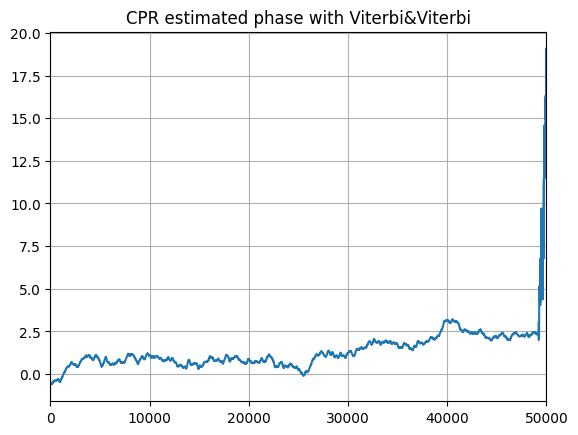

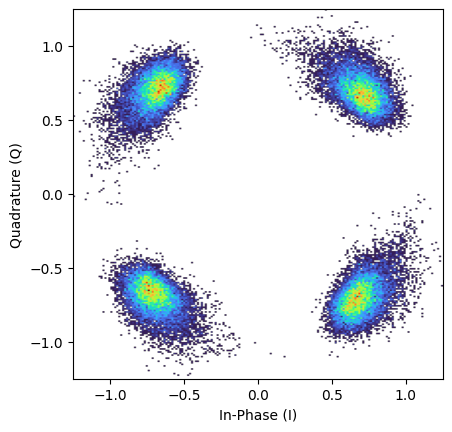

      pol.X        
 SER: 2.08e-04,  
 BER: 1.04e-04   
 SNR: 15.42 dB
 EVM: 2.87 %
  MI: 2.00 bits,
 GMI: 2.00 bits
NGMI: 1.00


In [601]:
# ------------------------------------------------------------------------------------------------
# 7) Carrier and phase recovery trials
# ------------------------------------------------------------------------------------------------
# Trial 2 Viterbi
paramCPR = parameters()
paramCPR.shapingFactor = 0
paramCPR.alg = 'viterbi'
paramCPR.N = 151
paramCPR.returnPhases = True
paramCPR.M   = M
paramCPR.constType ="qam"
paramCPR.Ts = 1/Rs

y_CPR_2, θ = cpr(y_EQ, paramCPR)


plt.figure()
plt.title('CPR estimated phase with Viterbi&Viterbi')
plt.plot(θ,'-')
plt.xlim(0, len(θ))
plt.grid();

discard = 1000

# plot constellations
#pconst([y_CPR_2[discard:-discard],d[discard:-discard]], pType='fast')
pconst(y_CPR_2[discard:-discard], cmap='turbo')

# Performance metrics
ind = np.arange(discard, d.shape[0]-discard)
BER, SER, SNR = fastBERcalc(y_CPR_2[ind], d[ind], M, 'qam', None)
GMI, NGMI = monteCarloGMI(y_CPR_2[ind], d[ind], M, 'qam', None)
MI       = monteCarloMI(y_CPR_2[ind], d[ind], M, 'qam', None)
EVM      = calcEVM(y_CPR_2[ind], M, 'qam', d[ind])

print('      pol.X        ')
print(' SER: %.2e,  '%(SER[0]))
print(' BER: %.2e   '%(BER[0]))
print(' SNR: %.2f dB'%(SNR[0]))
print(' EVM: %.2f %%'%(EVM[0]*100))
print('  MI: %.2f bits,'%(MI[0]))
print(' GMI: %.2f bits'%(GMI[0]))
print('NGMI: %.2f'%(NGMI[0]))

# Time taken for all of the system to simulate

In [602]:
print(f"{'-'*42}")
print(f"| {'DSP execution time benchmark':<30} | {'Time':<5} |")
print(f"| {'-'*30} | {'-'*5} |")
print(f"| {'Matched filtering':<30} | {timeMF:.2f} s|")
print(f"| {'CD compensation':<30} | {timeCDcomp:.2f} s|")
print(f"| {'Decimation':<30} | {timeDec:.2f} s|")
print(f"| {'Adaptive equalization':<30} | {timeEq:.2f} s|")
print(f"| {'Carrier phase recovery':<30} | {timeCPR:.2f} s|")
print(f"{'-'*42}")
print(f"| {'Total':<30} | {timeMF + timeCDcomp + timeDec + timeEq + timeCPR:.2f} s|")
print(f"{'-'*42}")

------------------------------------------
| DSP execution time benchmark   | Time  |
| ------------------------------ | ----- |
| Matched filtering              | 0.14 s|
| CD compensation                | 0.09 s|
| Decimation                     | 0.03 s|
| Adaptive equalization          | 0.12 s|
| Carrier phase recovery         | 0.61 s|
------------------------------------------
| Total                          | 0.98 s|
------------------------------------------
